In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

KMeans for poi_count Data

In [66]:
# Just for inspecting (and not forgetting about some potentially useful features from) the whole joined dataset
df_jointdata = pd.read_csv('joint_data.csv')
df_jointdata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,viewpoint,Müggeleck,0.000138
1,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,bench,NaN,0.000551
2,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,bench,NaN,0.000122
3,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,bench,NaN,0.000110
4,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,bench,NaN,0.000319


In [3]:
# Loading extracted poicount data from jointdata and making it easy to work with
df_poicount = pd.read_csv('category_count_per_route.csv')
df_poicount.fillna(0, inplace = True) # replacing NaN values with 0s
df_poicount = df_poicount.apply(np.int64)
df_poicount.rename(columns={"wp_count": "wp", "poi_count": "poi", "tree_count": "tree", "bench_count": "bench", "bench_count.1": "restaurant", "cafe_count": "cafe", "atm_count": "atm", "convenience_count": "convenience", "bar_count": "bar", "ice_cream_count": "ice_cream", "picnic_table_count": "picnic", "viewpoint_count": "viewpoint", "gallery_count": "gallery", "museum_count": "museum", "nightclub_count": "nightclub", "drinking_water_count": "drinking_water", "historic_count": "historic", "tourist_attraction_count": "t_attraction"}, inplace=True)
df_poicount.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,t_attraction
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

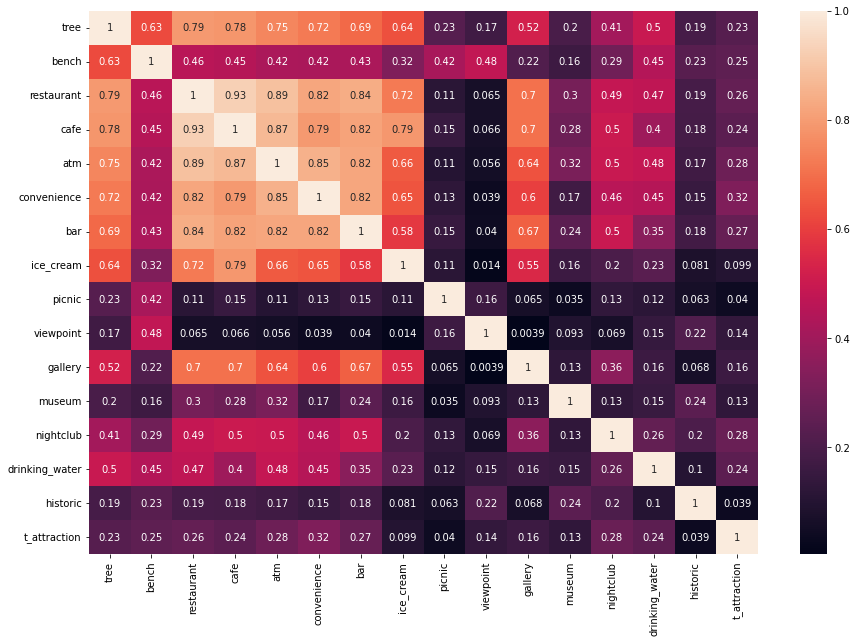

In [7]:
# Getting correlations for all the poits of interest (poi)
correlations = df_poicount.iloc[:, 3:].corr()
f,ax=plt.subplots(figsize=(15,10))
sns.heatmap(correlations,annot=True)

We can see that viewpoints often come along (meaning being on the same route) with benches and trees, which make sense. Restaurants go well together with cafes, convenience shops, atms, bars, ice cream shops and galleries, while viewpoints and picnic tables almost never are on the same routes as these. Trees, surprisingly, don't seem to join the nature routes that often, but tend to be on those routes with shops and cafes. Tourist attractions and historic features don't show a clear correlation and seem to be scattered among the other categories (we only have small amounts of those in our dataset though). Nightclubs seem to go best with bars and atms, but no clear correlation here.

In [8]:
# Writing the easier to work with df in a new csv file
df_poicount.to_csv(r'poicount.csv', index=False)

In [9]:
# Reading poicount data in as numpy arrays
poicount = np.genfromtxt('poicount.csv', delimiter=",", usecols=range(3, 19), skip_header=1)

In [10]:
# Inspecting if it worked well
poicount[0] # it does :)

array([14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [42]:
# Initialising the KMeans class with more or less standard parameters
kmeans = KMeans(init="random", n_clusters=3, n_init=50, max_iter=500)

In [43]:
# Applying the KMeans class to our data: it's going to run 50 times with 500 a max of interations each and return that resulat with the smallest SSE
kmeans.fit(poicount)
label = kmeans.labels_ # getting lables for latter mapping these to our dataframe

In [44]:
# Looking at the lowest SSE value
kmeans.inertia_

7194192.91662691

That high number is to be expected, because we have only 430 samples in 16 dimensions.

In [45]:
# Looking at the locations of the centroids
kmeans.cluster_centers_

array([[4.59431138e+01, 1.39161677e+01, 3.07784431e+00, 1.63173653e+00,
        6.31736527e-01, 3.95209581e-01, 5.08982036e-01, 1.85628743e-01,
        3.53293413e-01, 2.78443114e-01, 1.28742515e-01, 1.82634731e-01,
        1.04790419e-01, 8.08383234e-02, 7.18562874e-02, 5.98802395e-02],
       [4.24050633e+02, 5.21898734e+01, 1.51139241e+01, 8.74683544e+00,
        3.50632911e+00, 3.18987342e+00, 2.79746835e+00, 1.25316456e+00,
        5.69620253e-01, 6.58227848e-01, 6.70886076e-01, 5.44303797e-01,
        5.18987342e-01, 4.30379747e-01, 2.27848101e-01, 1.77215190e-01],
       [1.40500000e+03, 1.14705882e+02, 4.71176471e+01, 2.90588235e+01,
        1.28235294e+01, 9.47058824e+00, 8.88235294e+00, 2.94117647e+00,
        1.64705882e+00, 1.17647059e+00, 2.35294118e+00, 1.00000000e+00,
        1.76470588e+00, 1.58823529e+00, 4.11764706e-01, 3.52941176e-01]])

Looks like three distinct centroids, however when I ran this bevore, there were two quite similar ones which lead me to believe that it might be only two "real" clusters, because two of them where quite close to each other.

That variance in outcome probably results from the huge spaces between the datapoints.

In [47]:
# Nnumber of iterations required to converge
kmeans.n_iter_

13

13 interations (before it was 4) is suprisingly fast. The clusters seem to be suffuciently far apart from each other.

In [48]:
# Cluster assignments
kmeans.labels_[:5] #looking at the first 5

array([0, 0, 0, 0, 0])

Probably all "green routes with restaurats, cafes and so on" ... I'm sure that cluster is by far the largest.

In [49]:
# Checking how many times each lable appears
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 334, 1: 79, 2: 17}

Yes, there is one cluster that is much bigger than the others and that's probably the "green city route", because around 80% of our data is trees.

In [46]:
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns = [df_poicount.columns[3:]])
cluster_centers

,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,t_attraction
0,45.943114,13.916168,3.077844,1.631737,0.631737,0.395210,0.508982,0.185629,0.353293,0.278443,0.128743,0.182635,0.104790,0.080838,0.071856,0.059880
1,424.050633,52.189873,15.113924,8.746835,3.506329,3.189873,2.797468,1.253165,0.569620,0.658228,0.670886,0.544304,0.518987,0.430380,0.227848,0.177215
2,1405.000000,114.705882,47.117647,29.058824,12.823529,9.470588,8.882353,2.941176,1.647059,1.176471,2.352941,1.000000,1.764706,1.588235,0.411765,0.352941


In [56]:
# Mapping our labels into our dataframe (each route gets a label)
df_poicount_cluster = pd.concat([df_poicount, pd.DataFrame({'cluster':label})],axis=1)
df_poicount_cluster

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,t_attraction,cluster
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,3635047,2768,935,787,50,51,26,6,3,6,3,0,1,2,0,0,0,0,0,1
426,3470257,3422,1924,1608,239,42,12,9,4,1,0,2,2,0,1,0,2,1,1,2
427,364274,3585,828,681,47,38,24,14,9,6,4,0,0,1,2,0,0,2,0,1
428,3502672,3876,99,71,19,3,0,1,1,1,1,0,1,0,0,0,0,0,1,0


In [57]:
# Elbow method for finding the best k

# Increasing k by 1 with every step and store the SSE in a list
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 500}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    sse.append(kmeans.inertia_)
sse

[43656285.76744186,
 15583872.29083333,
 7194192.91662691,
 4186525.7494693776,
 2735574.8748075585,
 1969625.8074675968,
 1703064.1289922595,
 1569293.4524614203,
 1392513.3939517194,
 1429594.5380185172]

This confirms that there might as well be only two clusters. Let's visually check.

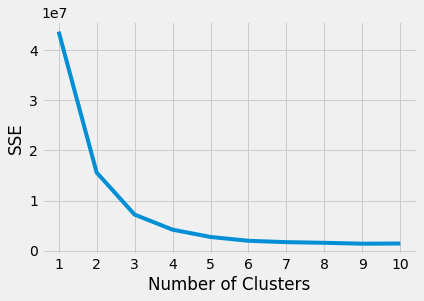

In [58]:
# Graphically finding the "elbow", where the SSE and the number of clusters are in reasonable trade-off to each other
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

2 or 3 clusters can be found. It seems that there are two clusters relatively near to each other (compared to the distance from the third cluster). Let's calculate it.

In [59]:
# Using the Python package "kneed" to identify the elbow point programmatically
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

Okay, seems to be 3 clusters. Let's still also implement the silhouette coefficient.

In [60]:
# Making a List for the silhouette coefficients for each k, starting at 2
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    score = silhouette_score(poicount, kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.8134777043053864,
 0.7285483137307086,
 0.723097498219662,
 0.6585220748121681,
 0.6452131359680884,
 0.5861195928222211,
 0.5464984482617165,
 0.5253853395990946,
 0.5430442176188255]

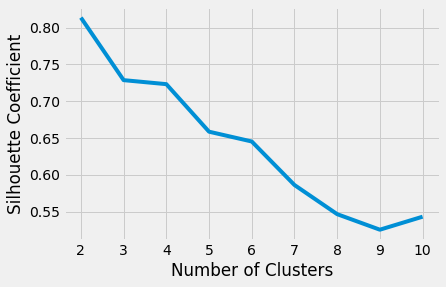

In [61]:
# Plotting the average silhouette scores for each k
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

This speaks for better going with 2 clusters. Two of the three clusters we had first found seem to be very near to each other, while the third one is further apart. Those first two could be considered as a joined cluster. Or, depending of how we want to implement our new knowlledge, maybe we should also go with three clusters.

Let's check what would happen if we'd go with two clusters only.

In [63]:
# Initialising the KMeans class with more or less standard parameters and applying it
kmeans = KMeans(init="random", n_clusters=2, n_init=50, max_iter=500)
kmeans.fit(poicount)

# Lookng at some statistics
print(kmeans.inertia_) #l owest SSE value
print(kmeans.cluster_centers_) #locations of the centroids
print(kmeans.n_iter_) #number of iterations required to converge
unique, counts = np.unique(kmeans.labels_, return_counts=True) # checking how many times each lable appears
dict(zip(unique, counts))

15583872.29083333
[[1.09896667e+03 9.21666667e+01 3.69666667e+01 2.19666667e+01
  9.63333333e+00 7.43333333e+00 7.06666667e+00 2.60000000e+00
  1.56666667e+00 9.00000000e-01 1.66666667e+00 8.00000000e-01
  1.13333333e+00 1.13333333e+00 3.00000000e-01 2.00000000e-01]
 [9.94025000e+01 1.98900000e+01 4.78500000e+00 2.67750000e+00
  1.04250000e+00 8.05000000e-01 8.25000000e-01 3.32500000e-01
  3.60000000e-01 3.45000000e-01 2.15000000e-01 2.42500000e-01
  1.80000000e-01 1.35000000e-01 1.00000000e-01 8.50000000e-02]]
10


{0: 30, 1: 400}

In [64]:
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns = [df_poicount.columns[3:]])
cluster_centers

,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,t_attraction
0,1098.966667,92.166667,36.966667,21.966667,9.633333,7.433333,7.066667,2.6000,1.566667,0.900,1.666667,0.8000,1.133333,1.133333,0.3,0.200
1,99.402500,19.890000,4.785000,2.677500,1.042500,0.805000,0.825000,0.3325,0.360000,0.345,0.215000,0.2425,0.180000,0.135000,0.1,0.085


What happens: the biggest cluster "eats" the second biggest. Which is a loss in information. Even if the second biggest cluster is just a subtype with many trees as well, it's worth keeing it.

Let's try some dimensionality reduction accompanied with plotting using 3 clusters

In [68]:
# Initialising the KMeans class with more or less standard parameters and applying it
kmeans = KMeans(init="random", n_clusters=3, n_init=50, max_iter=500)
kmeans.fit(poicount)
label = kmeans.labels_

# Principal Component Analysis
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df_poicount)
pca_df = pd.DataFrame(data=principal_comp,columns=['pca1','pca2'])
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':label})],axis=1)
pca_df.head()

,pca1,pca2,cluster
0,-460507.846333,-530.873509,1
1,329473.150824,-463.965885,1
2,-460508.846008,-534.464516,1
3,-525204.846291,-534.235319,1
4,-530330.845254,-545.998410,1


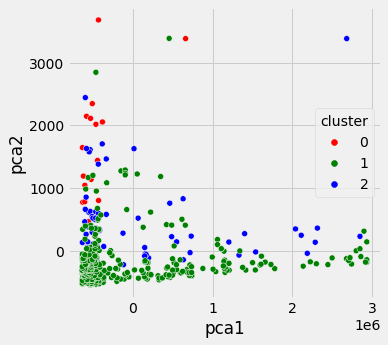

In [70]:
# Scatterplot of our clusters, reduced to two dimensions
plt.figure(figsize=(5,5))
ax= sns.scatterplot(x='pca1', y='pca2', hue='cluster',data=pca_df,palette=['red','green','blue'])
plt.show()

There seem to be many outliers! Next step would be to reduce them by datacleaning and run everything again.